# EDA on 311 data

In [267]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import keras
import glob

# Import Components for model building
# Import various components for model building
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import LSTM, Input, TimeDistributed
from keras.models import Model
from keras.optimizers import RMSprop

# Import the backend
from keras import backend as K


from sklearn.model_selection import train_test_split
% matplotlib inline

In [178]:
# Using the first 60000 data points
# Limited due to computational time and disc space
df = pd.read_csv('df_mini_60000.csv')

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 22 columns):
Unnamed: 0             60000 non-null int64
CaseID                 60000 non-null int64
Opened                 60000 non-null object
Closed                 58547 non-null object
Updated                60000 non-null object
Status                 60000 non-null object
Status Notes           35859 non-null object
Responsible Agency     60000 non-null object
Category               60000 non-null object
Request Type           60000 non-null object
Request Details        59091 non-null object
Address                60000 non-null object
Street                 58939 non-null object
Supervisor District    59987 non-null float64
Neighborhood           59801 non-null object
Police District        59769 non-null object
Latitude               60000 non-null float64
Longitude              60000 non-null float64
Point                  60000 non-null object
Source                 60000 non-nu

In [179]:
columns = list(df.columns)

columns = [column.lower().replace(' ', '_') for column in columns]

df.columns = columns

In [126]:
df.head()

,unnamed:_0,caseid,opened,closed,updated,status,status_notes,responsible_agency,category,request_type,...,street,supervisor_district,neighborhood,police_district,latitude,longitude,point,source,media_url,image
0,0,10667600,03/31/2019 12:12:13 PM,03/31/2019 01:34:27 PM,03/31/2019 01:34:27 PM,Closed,Pickup completed.,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,...,RANDOLPH ST,11.0,Merced Heights,TARAVAL,37.714110,-122.465725,"(37.71411, -122.465725)",Mobile/Open311,http://mobile311.sfgov.org/reports/10667600/ph...,[[[176 209 240]\n [103 124 151]\n [101 123 1...
1,1,10667603,03/31/2019 12:13:58 PM,03/31/2019 12:38:53 PM,03/31/2019 12:38:53 PM,Closed,Pickup completed.,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,...,GOLDEN GATE AVE,5.0,Western Addition,NORTHERN,37.779110,-122.435754,"(37.77911015, -122.43575424)",Mobile/Open311,http://mobile311.sfgov.org/reports/10667603/ph...,[[[ 36 37 31]\n [118 119 113]\n [ 49 54 ...
2,5,10667610,03/31/2019 12:15:00 PM,03/31/2019 01:18:00 PM,03/31/2019 01:18:00 PM,Closed,NaN,DPW Ops Queue,Graffiti,Graffiti on City_receptacle,...,GOLDEN GATE AVE,5.0,Western Addition,NORTHERN,37.779213,-122.435574,"(37.77921321, -122.43557434)",Mobile/Open311,http://mobile311.sfgov.org/reports/10667610/ph...,[[[155 143 129]\n [180 171 156]\n [171 162 1...
3,7,10667612,03/31/2019 12:16:00 PM,03/31/2019 01:14:00 PM,03/31/2019 01:14:00 PM,Closed,NaN,DPW - Bureau of Street Environmental Services - G,Graffiti,Graffiti on Other_enter_additional_details_below,...,GOLDEN GATE AVE,5.0,Western Addition,NORTHERN,37.779227,-122.435345,"(37.77922675, -122.43534543)",Mobile/Open311,http://mobile311.sfgov.org/reports/10667612/ph...,[[[118 125 133]\n [121 125 134]\n [126 130 1...
4,8,10667620,03/31/2019 12:19:56 PM,03/31/2019 01:26:09 PM,03/31/2019 01:26:09 PM,Closed,Pickup completed.,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,...,GUERRERO ST,8.0,Mission Dolores,MISSION,37.764888,-122.424161,"(37.76488767, -122.42416108)",Mobile/Open311,http://mobile311.sfgov.org/reports/10667620/ph...,[[[132 156 192]\n [ 81 110 144]\n [175 203 2...


In [39]:
# Check which images failed - twitter images, ~ 400/60000
df[df['image'].isna() == True].head()

,unnamed:_0,caseid,opened,closed,updated,status,status_notes,responsible_agency,category,request_type,...,street,supervisor_district,neighborhood,police_district,latitude,longitude,point,source,media_url,image
104,172,10668024,03/31/2019 02:13:00 PM,NaN,03/31/2019 05:55:01 PM,Open,accepted,DPW Ops Queue,Street and Sidewalk Cleaning,Hazardous Materials,...,2ND ST,6.0,South of Market,SOUTHERN,37.787357,-122.398750,"(37.78735733, -122.39875031)",Twitter,http://pic.twitter.com/sfRANdrIvi,NaN
465,891,6929105,03/12/2017 11:58:00 AM,03/13/2017 10:15:22 AM,03/13/2017 10:15:22 AM,Closed,NaN,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,...,FLOOD AVE,7.0,Sunnyside,INGLESIDE,37.729969,-122.440865,"(37.72996902, -122.44086456)",Twitter,http://pic.twitter.com/Z1duvxNDer,NaN
681,1473,6927363,03/11/2017 01:59:05 PM,03/15/2017 09:10:26 AM,03/15/2017 09:10:26 AM,Closed,NaN,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,...,CARROLL AVE,10.0,Bayview,BAYVIEW,37.725475,-122.394241,"(37.72547531, -122.39424133)",Twitter,https://twitter.com/edward_jll/status/84068080...,NaN
682,1474,6927357,03/11/2017 01:57:12 PM,03/11/2017 03:08:21 PM,03/11/2017 03:08:21 PM,Closed,Pickup completed.,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,...,3RD ST,10.0,Bayview,BAYVIEW,37.725475,-122.394241,"(37.72547531, -122.39424133)",Twitter,https://sf311.mediafunnel.com/#tabs/43/posts/m...,NaN
744,1619,6926931,03/11/2017 11:31:06 AM,03/12/2017 08:10:12 AM,03/12/2017 08:10:12 AM,Closed,NaN,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,...,TAYLOR ST,3.0,Russian Hill,CENTRAL,37.800053,-122.414093,"(37.80005264, -122.41409302)",Twitter,http://pic.twitter.com/AXrhpHDT54,NaN


In [96]:
print(df['request_type'].unique())
print(df['request_type'].nunique())

['Bulky Items' 'Graffiti on City_receptacle'
 'Graffiti on Other_enter_additional_details_below' 'Trees - Damaged_Tree'
 'City_garbage_can_overflowing' 'Encampment Reports' 'Graffiti on Pole'
 'General Cleaning' 'Graffiti on Building_residential' 'Double_Parking'
 'Sign - Defaced' 'Medical Waste' 'request_for_service'
 'Blocking_Bicycle_Lane' 'Blocking_Driveway_Cite_Tow' 'Human Waste'
 'Graffiti on Mail_box' 'Graffiti on Sidewalk_in_front_of_property'
 'Graffiti on Transit_Shelter_Platform' 'Tipped_over'
 'Other_Illegal_Parking' 'Graffiti on Signal_box'
 'Illegal Postings - Posted_on_Traffic_Light' 'Toters_left_out_24x7'
 'Add_remove_garbage_can' 'Graffiti on Building_commercial'
 'Park - Park_Patrol' 'Park - Structural_Maintenance'
 'Damaged Transit_Shelter_Platform' 'Hazardous Materials'
 'Trees - Tree_Other' 'Sewage_back_up' 'Parking_on_Sidewalk' 'Water_leak'
 'Blocking_Driveway_Cite_Only' 'Graffiti on Sign'
 'Graffiti on Parking_meter' 'Sign - Faded' 'Trees - Damaging_Property'
 'A

In [41]:
print(df['category'].unique())
print(df['category'].nunique())

['Street and Sidewalk Cleaning' 'Graffiti' 'Tree Maintenance'
 'Encampments' 'Parking Enforcement' 'Sign Repair'
 'General Request - PUBLIC WORKS' 'Litter Receptacles' 'Illegal Postings'
 'Rec and Park Requests' 'Damaged Property' 'Sewer Issues'
 'Abandoned Vehicle' 'Street Defects' 'Sidewalk or Curb'
 'Blocked Street or SideWalk' 'Streetlights' 'General Request - MTA'
 'Catch Basin Maintenance' 'General Request - DPH'
 'General Request - CENTRAL SHOPS' 'General Request - BUILDING INSPECTION'
 'General Request - ART COMMISSION' 'General Request - MUSEUMS'
 'General Request - PUC' 'General Request - ANIMAL CARE CONTROL'
 'General Request - FIRE DEPARTMENT' 'General Request - PLANNING'
 'General Request - PORT AUTHORITY']
29


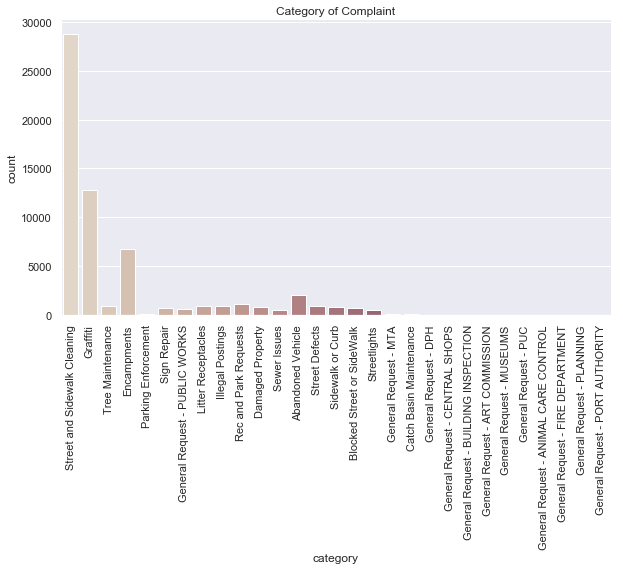

In [42]:
sns.catplot(x='category', kind='count', palette="ch:.25", height=5, aspect=2, data=df)
sns.set(rc={'figure.figsize':(10,20)})
plt.xticks(rotation=90)
plt.title('Category of Complaint')
plt.show()

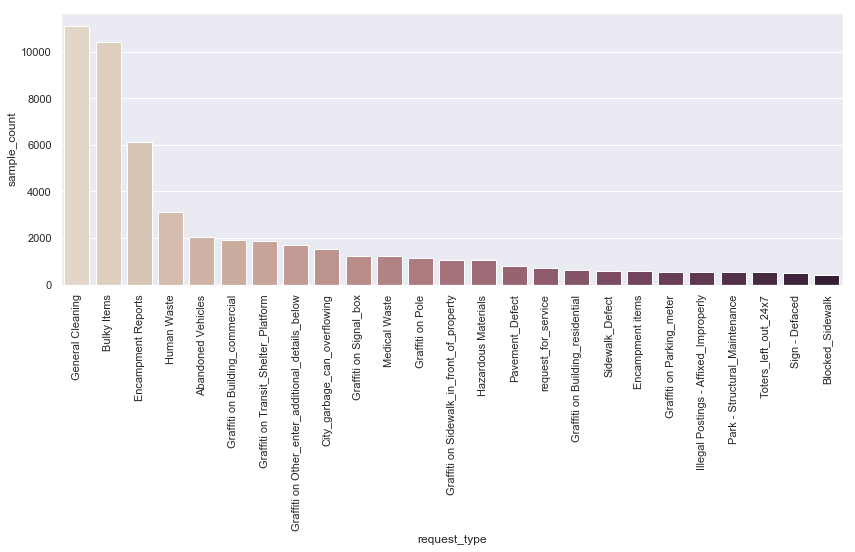

In [77]:
requested = df.groupby('request_type').count()['caseid'].sort_values(ascending=False)[0:25].reset_index()
requested.columns = ['request_type', 'sample_count']
ax = sns.barplot(x='request_type', 
                 y='sample_count', 
                 palette="ch:.25", 
                 data=requested)
plt.xticks(rotation=90)
plt.show()

In [180]:
df.dropna(subset=['image'], inplace=True)

In [181]:
df_images = pd.read_csv('images_only.csv')
cols = list(df_images.columns)
cols = [col.lower() for col in cols]
df_images.columns = cols

In [182]:
df = df.merge(df_images, 
              left_on='caseid', 
              right_on='caseid', 
              suffixes=('_orig', '_flat')
             )

In [184]:
df.drop(columns=['unnamed:_0', 'unnamed: 0'], inplace=True)

In [187]:
df.to_csv('both_info_and_flat.csv')

In [188]:
df.head()

,caseid,opened,closed,updated,status,status_notes,responsible_agency,category,request_type,request_details,...,supervisor_district,neighborhood,police_district,latitude,longitude,point,source,media_url,image_orig,image_flat
0,10667600,03/31/2019 12:12:13 PM,03/31/2019 01:34:27 PM,03/31/2019 01:34:27 PM,Closed,Pickup completed.,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,Furniture,...,11.0,Merced Heights,TARAVAL,37.714110,-122.465725,"(37.71411, -122.465725)",Mobile/Open311,http://mobile311.sfgov.org/reports/10667600/ph...,[[[176 209 240]\n [103 124 151]\n [101 123 1...,[176 209 240 ... 82 89 95]
1,10667603,03/31/2019 12:13:58 PM,03/31/2019 12:38:53 PM,03/31/2019 12:38:53 PM,Closed,Pickup completed.,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,Mattress,...,5.0,Western Addition,NORTHERN,37.779110,-122.435754,"(37.77911015, -122.43575424)",Mobile/Open311,http://mobile311.sfgov.org/reports/10667603/ph...,[[[ 36 37 31]\n [118 119 113]\n [ 49 54 ...,[ 36 37 31 ... 201 194 176]
2,10667610,03/31/2019 12:15:00 PM,03/31/2019 01:18:00 PM,03/31/2019 01:18:00 PM,Closed,NaN,DPW Ops Queue,Graffiti,Graffiti on City_receptacle,City_receptacle - Offensive,...,5.0,Western Addition,NORTHERN,37.779213,-122.435574,"(37.77921321, -122.43557434)",Mobile/Open311,http://mobile311.sfgov.org/reports/10667610/ph...,[[[155 143 129]\n [180 171 156]\n [171 162 1...,[155 143 129 ... 110 103 87]
3,10667612,03/31/2019 12:16:00 PM,03/31/2019 01:14:00 PM,03/31/2019 01:14:00 PM,Closed,NaN,DPW - Bureau of Street Environmental Services - G,Graffiti,Graffiti on Other_enter_additional_details_below,Other_enter_additional_details_below - Offensive,...,5.0,Western Addition,NORTHERN,37.779227,-122.435345,"(37.77922675, -122.43534543)",Mobile/Open311,http://mobile311.sfgov.org/reports/10667612/ph...,[[[118 125 133]\n [121 125 134]\n [126 130 1...,[118 125 133 ... 254 250 221]
4,10667620,03/31/2019 12:19:56 PM,03/31/2019 01:26:09 PM,03/31/2019 01:26:09 PM,Closed,Pickup completed.,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,Furniture,...,8.0,Mission Dolores,MISSION,37.764888,-122.424161,"(37.76488767, -122.42416108)",Mobile/Open311,http://mobile311.sfgov.org/reports/10667620/ph...,[[[132 156 192]\n [ 81 110 144]\n [175 203 2...,[132 156 192 ... 88 100 116]


In [162]:
df.image[0].size

'[[[176 209 240]\n  [103 124 151]\n  [101 123 146]\n  ...\n  [225 192 139]\n  [232 200 143]\n  [233 201 144]]\n\n [[186 221 249]\n  [106 126 150]\n  [100 122 145]\n  ...\n  [240 207 154]\n  [234 202 145]\n  [226 194 137]]\n\n [[197 224 245]\n  [123 153 187]\n  [102 124 147]\n  ...\n  [233 200 147]\n  [231 199 142]\n  [236 204 147]]\n\n ...\n\n [[ 64  72  74]\n  [ 72  80  82]\n  [ 63  71  73]\n  ...\n  [ 76  85  58]\n  [ 70  77  59]\n  [ 39  44  37]]\n\n [[ 69  77  79]\n  [ 69  77  79]\n  [ 82  90  92]\n  ...\n  [ 58  64  52]\n  [ 96 101  97]\n  [110 113 120]]\n\n [[ 63  71  73]\n  [ 67  75  77]\n  [ 61  69  71]\n  ...\n  [ 95 103 106]\n  [ 86  93  99]\n  [ 82  89  95]]]'

In [194]:
df.shape

(59628, 22)

In [201]:
X_train, X_test, y_train, y_test = train_test_split(np.fromstring(df['image_flat']),
                                                    df['request_type'],
                                                    test_size=0.25)

TypeError: a bytes-like object is required, not 'Series'

In [221]:
df_images.image[0]

'[176 209 240 ...  82  89  95]'

In [214]:
test = X_train[0].replace('[', '')
test = test.replace(']', '')

In [215]:
test2 = np.fromstring(test, sep=' ')

In [216]:
test2

array([154., 201., 243.])

In [217]:
test

'154 201 243 ...  97  81  68'

In [218]:
X_train[0]

'[154 201 243 ...  97  81  68]'

In [226]:
loaded_obj = pd.read_pickle('mini_0.pickle.gzde', compression='gzip')

In [230]:
loaded_obj.image[0].shape

(128, 128, 3)

In [231]:
loaded_obj.image.shape

(1000,)

In [238]:
loaded_obj.dropna(subset=['image'], inplace=True)

for idx, image in loaded_obj['image'].iteritems():
    loaded_obj['image'][idx] = np.reshape(image, 49152)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [239]:
loaded_obj.image

0       [176, 209, 240, 103, 124, 151, 101, 123, 146, ...
1       [36, 37, 31, 118, 119, 113, 49, 54, 50, 35, 7,...
5       [155, 143, 129, 180, 171, 156, 171, 162, 147, ...
7       [118, 125, 133, 121, 125, 134, 126, 130, 139, ...
8       [132, 156, 192, 81, 110, 144, 175, 203, 240, 1...
9       [44, 50, 62, 42, 48, 60, 42, 48, 60, 40, 47, 5...
10      [20, 23, 4, 47, 50, 29, 59, 58, 38, 39, 42, 23...
11      [194, 125, 153, 193, 124, 152, 192, 123, 151, ...
14      [73, 58, 51, 72, 57, 50, 79, 65, 54, 78, 69, 6...
17      [120, 116, 105, 174, 170, 159, 144, 140, 129, ...
19      [46, 48, 47, 39, 41, 40, 33, 37, 40, 9, 16, 24...
20      [96, 95, 101, 101, 100, 106, 101, 100, 106, 97...
21      [111, 172, 253, 110, 171, 252, 111, 172, 253, ...
22      [125, 147, 135, 117, 138, 133, 133, 150, 142, ...
24      [60, 59, 57, 57, 55, 56, 55, 53, 54, 55, 54, 5...
25      [148, 189, 217, 147, 188, 216, 151, 190, 219, ...
26      [58, 57, 55, 47, 46, 44, 47, 46, 44, 46, 46, 4...
27      [228, 

In [251]:
loaded_obj.image[0].shape

(49152,)

In [260]:
test = np.concatenate(loaded_obj.image.values.tolist(), axis=0)

In [262]:
test = test.reshape(994, 49152)

In [263]:
test.shape

(994, 49152)

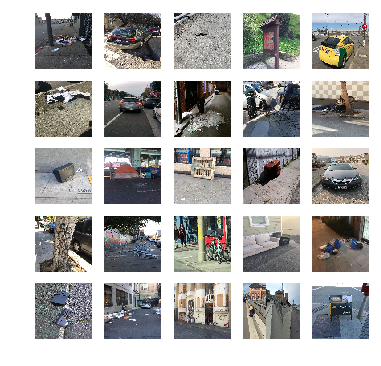

In [266]:
test2 = test.reshape(994, 128, 128, 3)

test2_image = test2.astype("uint8")

#Visualizing CIFAR 10
fig, axes1 = plt.subplots(5,5,figsize=(6,6))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(test2_image)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(test2_image[i:i+1][0])